## Last homework

This week we will apply techniques learned during the semester as a recap of the learned methods. We will use a dataset from the paper "Hurricane-induced selection on the morphology of an island lizard", where body parameters of lizards are measured on an island before and after the hurricane. We will make binary predictions if a lizard was measured before of after the hurricane in the upcoming tasks.

When a task is not fully described, try to come up with a reasonable solution!

Data source: https://www.nature.com/articles/s41586-018-0352-3#Sec7

#### 1. Load & prepare data
 - load the provided dataset
 - look for missing values, handle them! Be careful! (You can screw up the whole assignment here)
 - We will make binary predictions if a lizard was before of after the hurricane in the upcoming tasks. 
 - Convert all the features to numeric or binary features.
 - get rid of the ID column

#### 2. T-SNE
 - embed the data points into a 2D space via T-SNE (preprocess the data if needed). For embedding, use only the numerical features (So do not use Sex, Hurricane and Origin features)
 - what is common in the clusters that we got? visualize the embedded points by using different colour for the different fetautre values (eg on a plot show the female gekkos with red and the male ones with blue). Explore at least 4 features! Do we get separation by the Hurricane variable?

#### 3. Linear model + fine-tune
 - train and generate predictions with a logistic regression model using 5 fold cross validation
 - fine-tune the regularization strength for L2 regularization type!
 - show the ROC curve with the AUC value for the best model that you have found

#### 4. SVM + fine-tune
 - train and generate predictions with an SVM model using 5 fold cross validation
 - fine-tune the kernel parameters for 2 selected kernels
 - show the ROC curve with the AUC value for the best model that you have found

#### 5. RF + feature importances
 - train and generate predictions with a random forest classifier model using leave 5 fold cross validation
 - show the ROC curve with the AUC value for the best model that you have found
 - train a random forest model on all the data and show the 5 most important features based on feature importances of the model

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

# Task 1

In [2]:
df = pd.read_csv('Donihue 2018-01-00672 Hurricanes Data.csv')

In [3]:
df.shape

(164, 26)

In [4]:
df.isna().sum()

ID                 0
Hurricane          0
Origin             0
Sex                0
SVL                0
Femur              0
Tibia              0
Metatarsal         0
LongestToe         0
Humerus            0
Radius             0
Metacarpal         0
LongestFinger      0
FingerCount        1
ToeCount           1
FingerArea1        1
FingerArea2        1
FingerArea3        1
ToeArea1           1
ToeArea2           1
ToeArea3           1
MeanFingerArea     1
MeanToeArea        1
SumFingers        73
SumToes           73
MaxFingerForce    74
dtype: int64

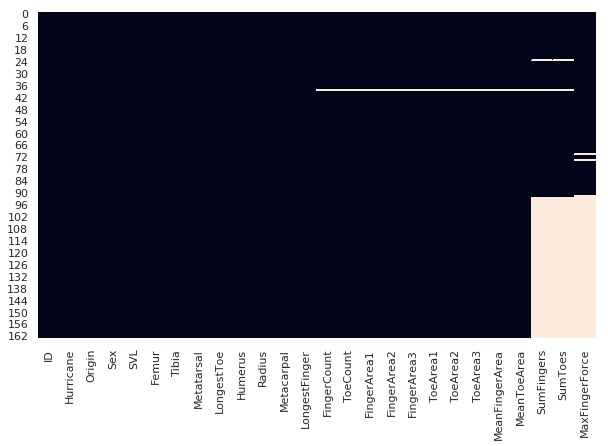

In [5]:
# checking missing vlaues
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)

In [6]:
# dropping these 3 rows beccause of too many missing values
df.drop(['SumFingers', 'SumToes', 'MaxFingerForce'], axis=1, inplace=True)

In [7]:
# then dropping rows with missing values
df = df.dropna(axis=0)

In [8]:
df.isna().sum()

ID                0
Hurricane         0
Origin            0
Sex               0
SVL               0
Femur             0
Tibia             0
Metatarsal        0
LongestToe        0
Humerus           0
Radius            0
Metacarpal        0
LongestFinger     0
FingerCount       0
ToeCount          0
FingerArea1       0
FingerArea2       0
FingerArea3       0
ToeArea1          0
ToeArea2          0
ToeArea3          0
MeanFingerArea    0
MeanToeArea       0
dtype: int64

In [9]:
# dropping ID column
df = df.reset_index()
df.drop(['ID', 'index'], axis=1, inplace=True)

In [10]:
# binarizing the categorical data
df['Hurricane'] = [0 if i == 'Before' else 1 for i in df['Hurricane']]
df['Sex'] = [0 if i == 'Male' else 1 for i in df['Sex']]
df['Origin'] = [0 if i == 'Pine Cay' else 1 for i in df['Origin']] # Water Cay == 1

# Task 2

In [11]:
df_t2 = df.drop(['Sex', 'Hurricane', 'Origin'], axis=1)

In [12]:
# scaling the data
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
df_t2n = scaler.fit_transform(df_t2)

In [13]:
from sklearn.manifold import TSNE

df_tsne = TSNE(n_components=2).fit_transform(df_t2n)

Text(0.5, 1.0, 'TSNE with Hurricane feature')

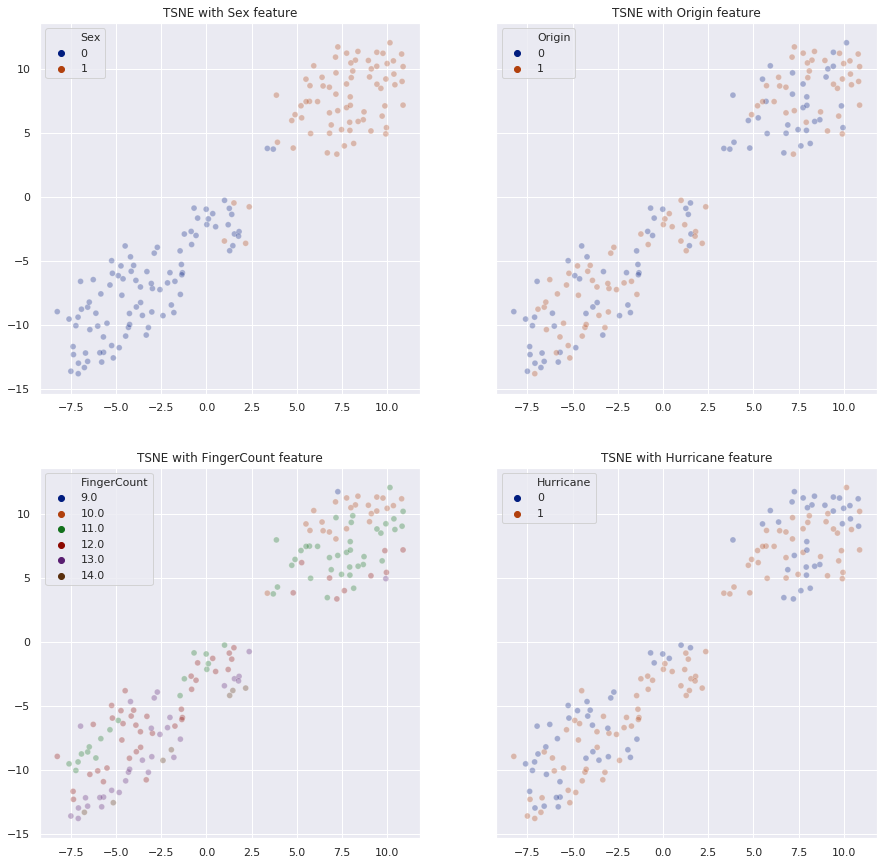

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)


sns.scatterplot(ax=axes[0,0], x=df_tsne[:,0], y=df_tsne[:,1], hue=df['Sex'], palette=sns.color_palette("dark", 2),
                legend="full", alpha=0.3).set_title('TSNE with Sex feature')


sns.scatterplot(ax=axes[0,1], x=df_tsne[:,0], y=df_tsne[:,1], hue=df['Origin'], palette=sns.color_palette("dark", 2),
                legend="full", alpha=0.3).set_title('TSNE with Origin feature')


sns.scatterplot(ax=axes[1,0], x=df_tsne[:,0], y=df_tsne[:,1], hue=df['FingerCount'], palette=sns.color_palette("dark", 6),
                legend="full", alpha=0.3).set_title('TSNE with FingerCount feature')


sns.scatterplot(ax=axes[1,1], x=df_tsne[:,0], y=df_tsne[:,1], hue=df['Hurricane'], palette=sns.color_palette("dark", 2),
                legend="full", alpha=0.3).set_title('TSNE with Hurricane feature')

The Sex feature gives us almost perfect separation, while Origin and FingerCount doesn't help us. The target feature, Hurricane doesn't separate the data well.

# Task 3

In [15]:
train_y = df['Hurricane']
train_x = df.drop(['Hurricane'], axis=1)

train_x = scaler.fit_transform(train_x)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV


lr = LogisticRegression(random_state=0)
pred = cross_val_predict(lr, train_x, train_y, cv=5)

In [17]:
from sklearn.metrics import accuracy_score

print('accuracy:', accuracy_score(pred, train_y))

accuracy: 0.8711656441717791


In [18]:
lr2 = LogisticRegression(random_state=0, penalty='l2', max_iter=2000)

In [19]:
grid={"C":np.logspace(0.1,5,20)}

lr_cv = GridSearchCV(lr2, grid, cv=5)
lr_cv.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000, random_state=0),
             param_grid={'C': array([1.25892541e+00, 2.27978944e+00, 4.12847324e+00, 7.47625680e+00,
       1.35387618e+01, 2.45173589e+01, 4.43985126e+01, 8.04013161e+01,
       1.45598833e+02, 2.63665090e+02, 4.77471406e+02, 8.64653503e+02,
       1.56580200e+03, 2.83551258e+03, 5.13483291e+03, 9.29867465e+03,
       1.68389803e+04, 3.04937283e+04, 5.52211267e+04, 1.00000000e+05])})

In [20]:
print("best parameters ",lr_cv.best_params_)
print("accuracy :",lr_cv.best_score_)

best parameters  {'C': 4.128473237715361}
accuracy : 0.8837121212121213


In [21]:
lr3 = LogisticRegression(random_state=0, penalty='l2', C=4.128473237715361, max_iter=2000)
pred2 = cross_val_predict(lr3, train_x, train_y, cv=5, method='predict_proba')

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr1, tpr1, thresholds= roc_curve(y_score=pred2[:,1], y_true=train_y)
roc_auc1 = roc_auc_score(train_y, pred2[:,1])

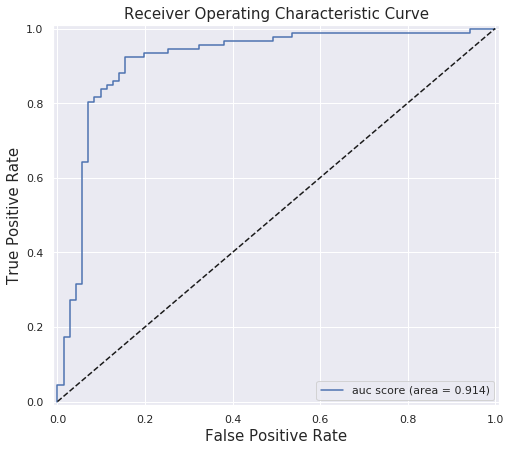

In [23]:
plt.figure(figsize=(8, 7))
plt.plot(fpr1, tpr1, label='auc score (area = %0.3f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Receiver Operating Characteristic Curve', size=15)
plt.legend(loc="lower right")

# Task 4

In [24]:
from sklearn.svm import SVC


svc = SVC()
pred3 = cross_val_predict(svc, train_x, train_y, cv=5)

In [25]:
print('accuracy:', accuracy_score(pred3, train_y))

accuracy: 0.7975460122699386


In [26]:
svc2 = SVC()

In [27]:
grid2 =  [{'gamma': np.linspace(1e-4, 10,50), 'coef0': np.linspace(1e-3, 10,50), 'kernel': ['poly', 'sigmoid']}]

svc_cv = GridSearchCV(svc2, grid2, cv=5)
svc_cv.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'coef0': array([1.00000000e-03, 2.05061224e-01, 4.09122449e-01, 6.13183673e-01,
       8.17244898e-01, 1.02130612e+00, 1.22536735e+00, 1.42942857e+00,
       1.63348980e+00, 1.83755102e+00, 2.04161224e+00, 2.24567347e+00,
       2.44973469e+00, 2.65379592e+00, 2.85785714e+00, 3.06191837e+00,
       3.26597959e+00, 3.47004082e+00, 3.67410204e+00, 3.8...
       5.71432857e+00, 5.91840816e+00, 6.12248776e+00, 6.32656735e+00,
       6.53064694e+00, 6.73472653e+00, 6.93880612e+00, 7.14288571e+00,
       7.34696531e+00, 7.55104490e+00, 7.75512449e+00, 7.95920408e+00,
       8.16328367e+00, 8.36736327e+00, 8.57144286e+00, 8.77552245e+00,
       8.97960204e+00, 9.18368163e+00, 9.38776122e+00, 9.59184082e+00,
       9.79592041e+00, 1.00000000e+01]),
                          'kernel': ['poly', 'sigmoid']}])

In [28]:
print("best parameters ",svc_cv.best_params_)
print("accuracy :",svc_cv.best_score_)

best parameters  {'coef0': 5.714714285714287, 'gamma': 0.20417959183673468, 'kernel': 'poly'}
accuracy : 0.8104166666666666


In [29]:
pred4 = SVC(kernel='poly', coef0=6.122836734693879, gamma=0.20417959183673468, probability=True
            ).fit(train_x, train_y).predict_proba(train_x)

In [30]:
fpr4, tpr4, thresholds= roc_curve(y_score=pred4[:,1], y_true=train_y)
roc_auc4 = roc_auc_score(train_y, pred4[:,1])

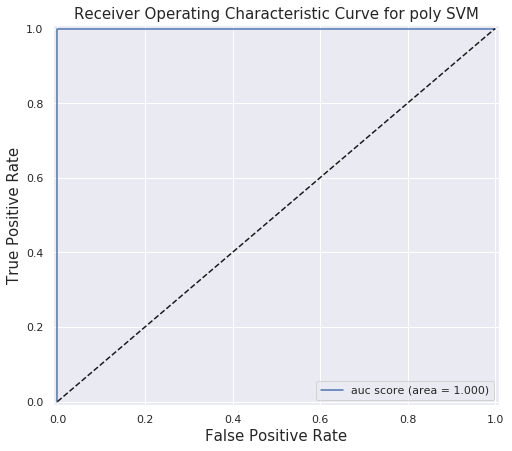

In [31]:
plt.figure(figsize=(8, 7))
plt.plot(fpr4, tpr4, label='auc score (area = %0.3f)' % roc_auc4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Receiver Operating Characteristic Curve for poly SVM', size=15)
plt.legend(loc="lower right")

# Task 5

In [32]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=42)
pred5 = cross_val_predict(rf, train_x, train_y, cv=5)

In [33]:
print('accuracy:', accuracy_score(pred5, train_y))

accuracy: 0.7361963190184049


In [34]:
rf2 = RandomForestClassifier(random_state=42)

In [35]:
grid3 = { 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

rf_cv = GridSearchCV(estimator=rf2, param_grid=grid3, cv= 5)
rf_cv.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [36]:
print("best parameters ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

best parameters  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
accuracy : 0.7428030303030303


In [37]:
pred6 = RandomForestClassifier(random_state=42, criterion='gini', max_depth= 8, max_features='auto',
                            n_estimators=500).fit(train_x, train_y).predict_proba(train_x)

In [38]:
print('accuracy:', accuracy_score(np.argmax(pred6,1), train_y))

accuracy: 1.0


In [39]:
fpr5, tpr5, thresholds= roc_curve(y_score=pred6[:,1], y_true=train_y)
roc_auc5 = roc_auc_score(train_y, pred6[:,1])

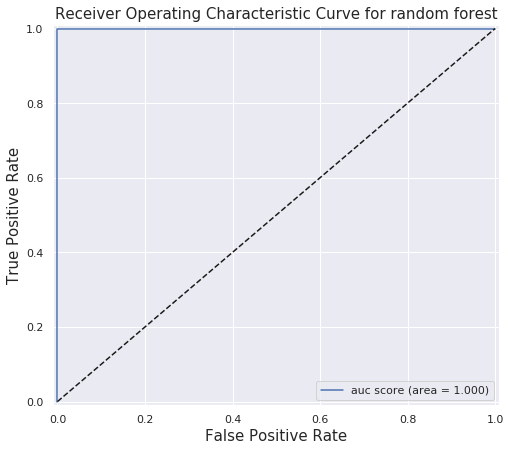

In [40]:
plt.figure(figsize=(8, 7))
plt.plot(fpr5, tpr5, label='auc score (area = %0.3f)' % roc_auc5)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Receiver Operating Characteristic Curve for random forest', size=15)
plt.legend(loc="lower right")

In [41]:
rfc = RandomForestClassifier(random_state=42).fit(train_x, train_y)

In [42]:
# creating a list of the most important features and their importances
fi = [[df.columns[:-1][i], rfc.feature_importances_[i]] for i in range(len(df.columns[:-1]))]
fi = sorted(fi, key = lambda x: x[1])[::-1]

Text(0.5, 1.0, 'Top 5 most important features and their importances')

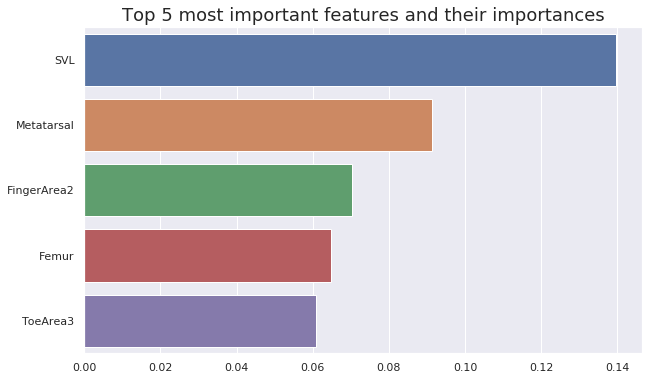

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[fi[i][1] for i in range(len(fi))][:5], y=[fi[i][0] for i in range(len(fi))][:5])
plt.title('Top 5 most important features and their importances', size=18)